In [42]:
import mediapipe as mp

import numpy as np
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import cv2
import matplotlib.pyplot as plt
import math
import os
import enum

root_path = '../../data/mediapipe'
test_image = os.path.join(root_path,'test14.jpg')
model_path = os.path.join(root_path,'pose_landmarker_heavy.task')

class PoseLandmark(enum.IntEnum):
  """The 33 pose landmarks."""
  NOSE = 0
  LEFT_EYE_INNER = 1
  LEFT_EYE = 2
  LEFT_EYE_OUTER = 3
  RIGHT_EYE_INNER = 4
  RIGHT_EYE = 5
  RIGHT_EYE_OUTER = 6
  LEFT_EAR = 7
  RIGHT_EAR = 8
  MOUTH_LEFT = 9
  MOUTH_RIGHT = 10
  LEFT_SHOULDER = 11
  RIGHT_SHOULDER = 12
  LEFT_ELBOW = 13
  RIGHT_ELBOW = 14
  LEFT_WRIST = 15
  RIGHT_WRIST = 16
  LEFT_PINKY = 17
  RIGHT_PINKY = 18
  LEFT_INDEX = 19
  RIGHT_INDEX = 20
  LEFT_THUMB = 21
  RIGHT_THUMB = 22
  LEFT_HIP = 23
  RIGHT_HIP = 24
  LEFT_KNEE = 25
  RIGHT_KNEE = 26
  LEFT_ANKLE = 27
  RIGHT_ANKLE = 28
  LEFT_HEEL = 29
  RIGHT_HEEL = 30
  LEFT_FOOT_INDEX = 31
  RIGHT_FOOT_INDEX = 32



def calculate_angle(a, b, c):
    a = np.array(a)  # 第一个点
    b = np.array(b)  # 第二个点（角的顶点）
    c = np.array(c)  # 第三个点

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    if angle > 180.0:
        angle = 360.0 - angle
    return angle
def calculate_angle_between_points(p1, p2, p3):
    # 计算向量
    vector_a = np.array(p2) - np.array(p1)
    vector_b = np.array(p2) - np.array(p3)
    # 计算点积
    dot_product = np.dot(vector_a, vector_b)
    # 计算向量的模长
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    # 计算 cos(theta)
    cos_theta = dot_product / (norm_a * norm_b)
    # 计算角度（弧度）
    angle_rad = np.arccos(cos_theta)
    # 转换为角度（度）
    angle_deg = np.degrees(angle_rad)

    return angle_deg


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  world = detection_result.pose_world_landmarks
  annotated_image = np.copy(rgb_image)

  print(len(pose_landmarks_list))
  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])

    mp_pose = mp.solutions.pose
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_drawing = mp.solutions.drawing_utils
    # 获取默认的关键点样式
    pose_landmark_style = mp_drawing_styles.get_default_pose_landmarks_style()

    # 修改样式（例如，更改关键点的颜色）
    # pose_landmark_style[mp_pose.PoseLandmark.LEFT_SHOULDER] = mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=2)
    # pose_landmark_style[mp_pose.PoseLandmark.RIGHT_SHOULDER] = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=2)

    # 修改所有关键点的颜色
    point_color = (0, 0, 255)
    line_color = (0, 255, 255)  # 你想要的颜色 (BGR格式)
    line_thickness = 1  # 设置线条厚度
    for landmark in pose_landmark_style:
        pose_landmark_style[landmark] = mp_drawing.DrawingSpec(color=point_color, thickness=1, circle_radius=4)

    image_height, image_width, _ = annotated_image.shape
    
    keyspointsAngle = [
        [
          23,
          25,
          27
        ],
        [
          24,
          26,
          28
        ],
        [11,13,15]
      #   [
      #     26,
      #     28,
      #     32
      #   ],
      #   [
      #     25,
      #     27,
      #     31
      #   ]
    ]
    for keys in keyspointsAngle:
      a = keys[0]
      b = keys[1]
      c = keys[2]
      # shoulder = [world[0][a].x,
      #           world[0][a].y,
      #           world[0][a].z]
      # elbow = [world[0][b].x,
      #         world[0][b].y,
      #         world[0][b].z]
      # wrist = [world[0][c].x,
      #         world[0][c].y,
      #         world[0][c].z]
      shoulder = [pose_landmarks[a].x* image_width,
                        pose_landmarks[a].y* image_height,
                        0]
      elbow = [pose_landmarks[b].x* image_width,
              pose_landmarks[b].y* image_height,
              0]
      wrist = [pose_landmarks[c].x* image_width,
              pose_landmarks[c].y* image_height,
             0]
      if c == 0:
          wrist = [0,0,0]
      
      
      # shoulder = [pose_landmarks[a].x * image_width,
      #           pose_landmarks[a].y * image_height]
      elbow2 = [pose_landmarks[b].x * image_width,
              pose_landmarks[b].y * image_height]
      # wrist = [pose_landmarks[c].x * image_width,
      #         pose_landmarks[c].y * image_height]
      
      # angle = calculate_angle(shoulder, elbow, wrist)
      angle = calculate_angle_between_points(shoulder, elbow, wrist)
      cv2.putText(annotated_image, str(int(angle)),
                        tuple(np.multiply(elbow2, [1, 1]).astype(int)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA
                        )

     # 例如，计算肩部、肘部和手腕的角度
    # shoulder2 = [pose_landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x * image_width,
    #             pose_landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y * image_height]
    # elbow2 = [pose_landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x * image_width,
    #         pose_landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y * image_height]
    # wrist2 = [pose_landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x * image_width,
    #         pose_landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y * image_height]
    
    # angle2 = calculate_angle(shoulder2, elbow2, wrist2)
    # cv2.putText(annotated_image, str(int(angle2)),
    #                     tuple(np.multiply(elbow2, [1, 1]).astype(int)),
    #                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)



    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      pose_landmark_style,
      connection_drawing_spec=mp_drawing.DrawingSpec(color=line_color, thickness=line_thickness))
  return annotated_image

def calculate_angle_between_lines(p1, p2, p3, p4):
    """
    计算通过点 p1, p2 和点 p3, p4 定义的两条直线之间的夹角。
    
    p1, p2: 第一条直线上的两个点
    p3, p4: 第二条直线上的两个点
    返回值：两条直线之间的夹角（单位：度）
    """
    # 计算向量
    vector1 = (p2[0] - p1[0], p2[1] - p1[1])
    vector2 = (p4[0] - p3[0], p4[1] - p3[1])
    
    # 计算向量的点积
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]
    
    # 计算向量的模
    magnitude1 = math.sqrt(vector1[0]**2 + vector1[1]**2)
    magnitude2 = math.sqrt(vector2[0]**2 + vector2[1]**2)
    
    # 计算夹角的余弦值
    cos_angle = dot_product / (magnitude1 * magnitude2)
    
    # 通过反余弦函数计算夹角（单位：弧度）
    angle_rad = math.acos(cos_angle)
    
    # 将夹角转换为度
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg



PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.3295981287956238, y=0.5310978889465332, z=-0.3793283700942993, visibility=0.9895716905593872, presence=0.999263346195221), NormalizedLandmark(x=0.32544633746147156, y=0.5349944233894348, z=-0.3846704065799713, visibility=0.9935752749443054, presence=0.9994713664054871), NormalizedLandmark(x=0.3243557810783386, y=0.533623456954956, z=-0.38492587208747864, visibility=0.9929337501525879, presence=0.9995274543762207), NormalizedLandmark(x=0.3230515718460083, y=0.5326393842697144, z=-0.38483381271362305, visibility=0.9949540495872498, presence=0.9993780851364136), NormalizedLandmark(x=0.32895737886428833, y=0.5392307043075562, z=-0.38510629534721375, visibility=0.9926143884658813, presence=0.9988964796066284), NormalizedLandmark(x=0.3300950229167938, y=0.5414997935295105, z=-0.3853510320186615, visibility=0.9928913116455078, presence=0.9987823367118835), NormalizedLandmark(x=0.33131927251815796, y=0.5435503125190735, z=-0.38555458

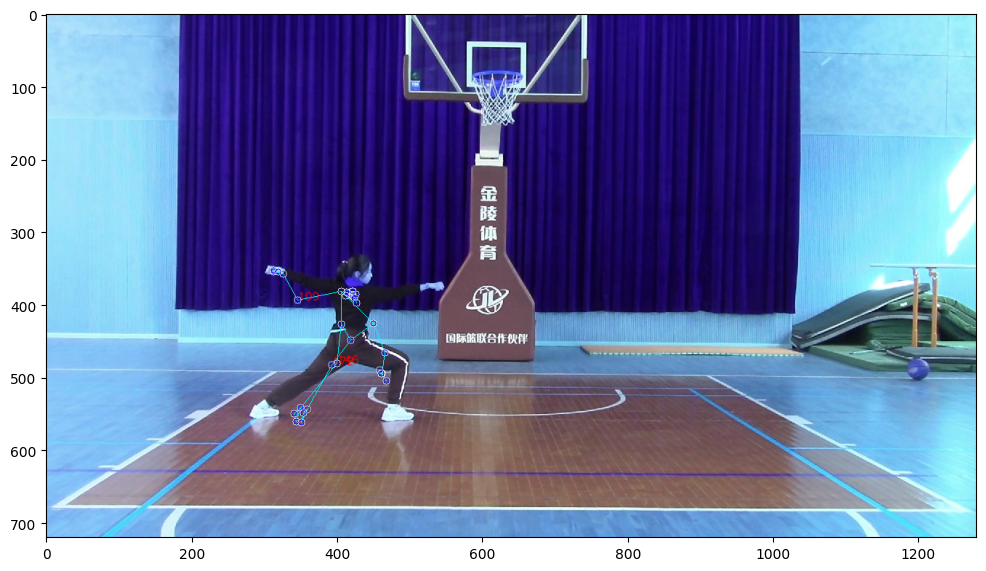

In [43]:

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a pose landmarker instance with the video mode:
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE)

with PoseLandmarker.create_from_options(options) as landmarker:
    # mp_image = mp.Image.create_from_file(test_image)
    # mp_image = cv2.cvtColor(mp_image, cv2.COLOR_RGB2BGR)
    image_bgr = cv2.imread(test_image, cv2.IMREAD_COLOR)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_bgr)

    pose_landmarker_result = landmarker.detect(mp_image)
    print(pose_landmarker_result)
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), pose_landmarker_result)
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image)
    # 显示图像
    plt.show()
    # cv2.imshow('Image', annotated_image)
    # # 等待键盘事件，参数为等待时间（毫秒）
    # cv2.waitKey(0)  # 等待直到有键盘事件
    # cv2.destroyAllWindows()




In [1]:
with PoseLandmarker.create_from_options(options) as landmarker:
    # mp_image = mp.Image.create_from_file(test_image)
    # mp_image = cv2.cvtColor(mp_image, cv2.COLOR_RGB2BGR)
    image_bgr = cv2.imread(test_image, cv2.IMREAD_COLOR)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_bgr)

    pose_landmarker_result = landmarker.detect(mp_image)
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), pose_landmarker_result)
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image)
    # 显示图像
    plt.show()

NameError: name 'PoseLandmarker' is not defined

In [41]:
def calculate_angle_and_direction(A, B, C):
    # 向量 AB 和 BC
    AB = np.array([B[0] - A[0], B[1] - A[1]])
    BC = np.array([C[0] - B[0], C[1] - B[1]])
    
    # 计算向量的模
    norm_AB = np.linalg.norm(AB)
    norm_BC = np.linalg.norm(BC)
    
    # 计算向量的点积
    dot_product = np.dot(AB, BC)
    
    # 计算夹角
    angle = np.arccos(dot_product / (norm_AB * norm_BC))
    angle_degrees = np.degrees(angle)
    
    # 计算向量的叉积来确定方向
    cross_product = np.cross(AB, BC)
    
    if cross_product > 0:
        direction = -1 #"逆时针"
    elif cross_product < 0:
        direction = 1 #"顺时针"
    else:
        direction = 0 #"共线"
    
    return angle_degrees, direction

A = (1, 1)
B = (2, 3)
C = (4, 4)

angle, direction = calculate_angle_and_direction(A, B, C)
print(f"夹角: {angle} 度, 方向: {direction}")

夹角: 36.86989764584404 度, 方向: 顺时针


In [104]:
def normalized_distance(value, min_val, max_val):
    if min_val == max_val:
        raise ValueError("min_val and max_val cannot be the same")
    
    normalized = (value - min_val) / (max_val - min_val)
    return normalized

def standardized_proximity(value, min_val, max_val):
    mid = (min_val + max_val) / 2
    proximity = 1 - (2 * abs(value - mid) / (max_val - min_val))
    return max(0, proximity)

def proximity_to_interval(value, min_val, max_val):
    if min_val > max_val:
        raise ValueError("min_val should not be greater than max_val")

    if min_val <= value <= max_val:
        return 1.0  # 值在区间内，返回1

    # 计算值到区间最近边界的距离
    distance_to_closest_bound = min(abs(value - min_val), abs(value - max_val))
    interval_range = max_val - min_val
    
    # 归一化距离，使其返回值接近1
    normalized_distance = distance_to_closest_bound / interval_range
    proximity = 1 / (1 + normalized_distance)  # 将距离映射到接近1的值

    return proximity

r = proximity_to_interval(3,2,5)
r

1.0